# Running Computational Alchemy for Catalysis: Binding Energy Predictions
This notebook outlines Python functions that use information from VASP calculations to predict descriptors for hypothetical catalyst. These functions utilize tools from the Atomic Simulation Environment (ASE) to manipulate catalyst surface models and perform calculations with computational alchemy. 

In this example, we apply computational alchemy on reference calculcations of CO binding on Pd(111) to predict binding energies (BEs) of CO on hypothetical alloys of Pd(111). 

Here we make ASE Atoms objects with VASP POSCARs and CONTCARs for the bare catalyst surface (slab) and the catalyst surface with an adsorbate (ads). These models and the results of the VASP calculations for each will be used as our reference for computational alchemy calculations.

In [2]:
from ase.io import read 
from ase.visualize import view
slab = read('POSCAR_pd',format='vasp')
slab_contcar = read('CONTCAR_pd',format='vasp')
ads = read('POSCAR_pd_co',format='vasp')
ads_contcar = read('CONTCAR_pd_co',format='vasp')

To do computational alchemy, we label the atoms in our models using indexes assigned by ASE.

However, it's very likely that the atom indexes between slab and ads won't match. For instance, the atom located at the origin of the unit cell in slab may be indexed as 0, while the atom at the origin in ads may be indexed as 1. 

Here we use the **pairs** function to find the index of an atom in ads that share the same position in the unit cell with an atom in slab.

In [3]:
from ads_slab_pairs import pairs
p = pairs(slab,ads)

print('Ordering: [slab index, ads index]')
print(p)

Ordering: [slab index, ads index]
[[0, 11], [1, 4], [2, 5], [3, 6], [4, 7], [5, 8], [6, 9], [7, 10], [8, 21], [9, 20], [10, 12], [11, 13], [12, 14], [13, 15], [14, 16], [15, 17], [16, 18], [17, 19], [18, 3], [19, 2]]


### Working with electrostatic potentials in VASP OUTCAR
Next we can grab the atom-centered electrostatic potentials (ESPs) printed at the end of the OUTCAR with **grab_esp**. 
Here we grab ESPs for slab and ads and calculate the differences with **espdiff**. The ESP differnces define the alchemical derivatives that facilitate predictions with alchemy.

In [4]:
from elec_stat_pot import (grab_esp,espdiff,remove_duplicate_espdiffs,heatmap)
slab_elec = grab_esp(poscar='POSCAR_pd',outcar='OUTCAR_pd')
ads_elec = grab_esp(poscar='POSCAR_pd_co',outcar='OUTCAR_pd_co')
from numpy import round
diffs = [round(e,4) for e in espdiff(elec1=slab_elec,elec2=ads_elec,pair=p)]

In [5]:
print('Atom-centered electrostatic potentials:')
print('Slab:')
print(slab_elec)
print('')
print('Ads:')
print(ads_elec)
print('')
print('Differences in electrostatic potentials between ads and slab')
print(diffs)
print('')

Atom-centered electrostatic potentials:
Slab:
[-79.4201, -79.4135, -79.4135, -79.7811, -79.7811, -79.7811, -79.7811, -79.8361, -79.8361, -79.8361, -79.8361, -79.7831, -79.7831, -79.7831, -79.7831, -79.4201, -79.4201, -79.4201, -79.4135, -79.4135]

Ads:
[-56.4382, -76.7351, -79.3969, -79.8405, -79.8405, -79.8405, -79.7963, -79.7191, -79.7963, -79.7963, -79.8641, -79.5004, -79.8903, -79.8603, -79.8534, -79.8534, -79.8534, -79.5004, -79.5005, -79.5004, -79.8641, -79.8641]

Differences in electrostatic potentials between ads and slab
[-0.0803, -0.427, -0.427, -0.0152, 0.062, -0.0152, -0.0152, -0.028, -0.028, -0.028, -0.0542, -0.0772, -0.0703, -0.0703, -0.0703, -0.0803, -0.0804, -0.0803, -0.427, 0.0166]



### Visualizing alchemical derivatives
With the **heatmap** function, visualize the alchemical derivatives with ASE GUI by running the cell below, pressing "c" in ASE GUI, and under "Choose how the atoms are colored:" selecting "By initial charge" 

In [6]:
slab_vis = heatmap(poscar='POSCAR_pd',
                   dexlist=[dex[0] for dex in p],
                   espdiffs=diffs)
view(slab_vis)

### Creating hypothetical materials by making transmutations
Below we use the **index_transmuted** function to grab indexes of atoms that we want to transmute in our reference slabs. We specify the number of transmutable atoms by setting "transmute_num." 

This function also grabs indexes of atoms at the bottom of the slab that we can counter-transmute to maintain isoelectronicity. We set the number of counter-transmutable atoms with "counter_num."

In [7]:
from ase import Atom
from alloy_index import index_transmuted, transmuter, transmuted_directory_names
metal = Atom('Pd')
[transmute, counter] = index_transmuted(slab=slab,
                                        transmute_atom_sym=metal.symbol,
                                        counter_atom_sym=metal.symbol,
                                        transmute_num=8,
                                        counter_num=8,
                                        symmetric = False)

We can filter through the ESP differences centered at each transmutable atom with **remove_duplicate_espdiffs**. This reduces the number of systems to study by recording unique alchemical derivatives, the minimum amount needed to thoroughly assess alchemy. This step is optional if you want to make all possible transmutations to your reference system and assess them all.

In [10]:
new_transmute = remove_duplicate_espdiffs(dexlist=transmute,
                                          espdiffs=diffs)
new_counter = remove_duplicate_espdiffs(dexlist=counter,
                                        espdiffs=diffs)

Unique Electrostatic Potential Differences:
dict_values([-0.427, 0.0166, -0.0152, 0.062])

Unique Electrostatic Potential Differences WITHIN A TOLERANCE VALUE:
[-0.427, 0.0166, -0.0152, 0.062]
 
Unique Electrostatic Potential Differences:
dict_values([-0.0803, -0.0804, -0.0772, -0.0703])

Unique Electrostatic Potential Differences WITHIN A TOLERANCE VALUE:
[-0.0703]
 


In [11]:
print('Atoms to be transmuted with unique electrostatic potential differences.')
print(new_transmute)
print('')
print('Atoms to be counter transmuted with unique electrostatic potential differences.')
print(new_counter)
print('')

Atoms to be transmuted with unique electrostatic potential differences.
[1, 19, 3, 4]

Atoms to be counter transmuted with unique electrostatic potential differences.
[12]



In this example, we transmute surface Pd atoms to Ag (change in nuclear charge of +1) and counter-transmute Pd atoms in the bottom layers to Rh (change in nuclear charge of -1). Below we construct an array with Ag and Rh Atom objects to use in the **transmuter** function.

In [12]:
charge = 1
transmute_atom = Atom(metal.symbol)
transmute_atom.number += charge
counter_transmute_atom = Atom(metal.symbol)
counter_transmute_atom.number -= charge
all_transmute = [counter_transmute_atom,transmute_atom]

In the next two cells, we make transmutations to Atoms objects of slab and ads from their respective CONTCARs and give labels for each new model with the **transmuted_directory_names** function. Now we can visualize these new systems and write POSCARs to do VASP calculations for benchmarking.

In [13]:
from ase import Atom
print('Transmuted Slab Labels')
transmuted_slabs = []
dir_slab = []
for i,c in enumerate(new_counter):
    for j,t in enumerate(new_transmute):
        transmuted_slabs.append(transmuter(slab=slab_contcar,
                                           atomdex=[c,t],
                                           trans=all_transmute))
        dir_slab.append(transmuted_directory_names(bdex=i,
                                                   tdex=j,
                                                   dexes=[c,t],
                                                   atoms_array=all_transmute))
        print(dir_slab[j])

Transmuted Slab Labels
0.0.Rh12.Ag1
0.1.Rh12.Ag19
0.2.Rh12.Ag3
0.3.Rh12.Ag4


In [14]:
print('Transmuted Ads Labels')
transmuted_ads = []
dir_ads = []
for i,c in enumerate(new_counter):
    c = p[c][1]
    for j,t in enumerate(new_transmute):
        t = p[t][1]
        transmuted_ads.append(transmuter(slab=ads_contcar,
                                         atomdex=[c,t],
                                         trans=all_transmute))
        dir_ads.append(transmuted_directory_names(bdex=i,
                                                  tdex=j,
                                                  dexes=[c,t],
                                                  atoms_array=all_transmute))
        print(dir_ads[j])

Transmuted Ads Labels
0.0.Rh14.Ag4
0.1.Rh14.Ag2
0.2.Rh14.Ag6
0.3.Rh14.Ag7


We can view a hyothetical alloy model bare and with the adsorbate with ASE GUI.

In [15]:
view(transmuted_slabs[0])
view(transmuted_ads[0])

For validation purposes, we setup directories to run VASP calculations on our transmuted surface models.

In [ ]:
import os
from ase.io import write
from vasp_setup import make_potcar,make_kpoints,make_incar,make_job_script
for i,s in enumerate(transmuted_slabs):
    d = dir_slab[i]
    os.mkdir(d)
    os.chdir(d)
    home = os.getcwd()
    write('POSCAR',s,'vasp',sort=True)
    make_potcar(home,'/home/chaszg18/potcars/')
    make_kpoints(home,d,kspacing=[8,8,1])
    make_incar(home,d,encut=350,ismear=1,sigma=0.4,ibrion=-1,nsw=0)
    make_job_script(home,d,jobnum=i,nodes=2,cores=28,cluster='mpi',partition='opa',hours=6)
    os.chdir('../')
    
for i,s in enumerate(transmuted_ads):
    d = dir_ads[i]
    os.mkdir(d)
    os.chdir(d)
    home = os.getcwd()
    write('POSCAR',s,'vasp',sort=True)
    make_potcar(home,'/home/chaszg18/potcars/')
    make_kpoints(home,d,kspacing=[8,8,1])
    make_incar(home,d,encut=350,ismear=1,sigma=0.4,ibrion=-1,nsw=0)
    make_job_script(home,d,jobnum=i,nodes=2,cores=28,cluster='mpi',partition='opa',hours=6)
    os.chdir('../')
    

### Calculating binding energy (BE) with computational alchemy
Once all VASP calculations are complete, we can calculate binding energies on our transmuted surfaces using alchemy, then compare against DFT binding energies.

First we calculate the binding energy of our reference system.

In [16]:
from read_oszicar import grab_energy
adsorbate_energy = -.14799149E+02
slab_energy = grab_energy(oszicar='OSZICAR_pd')
ads_energy = grab_energy(oszicar='OSZICAR_pd_co')
ref_be = slab_energy + adsorbate_energy - ads_energy

Next we grab energies of transmuted surfaces from VASP calculations and calculating binding energies for each.

In [17]:
transmuted_slab_energy = [grab_energy(oszicar='results/'+d+'/OSZICAR') for d in dir_slab]
transmuted_ads_energy = [grab_energy(oszicar='results/'+d+'/OSZICAR') for d in dir_ads]

In [18]:
transmuted_be = [transmuted_slab_energy[i] + adsorbate_energy - transmuted_ads_energy[i] for i in range(len(transmuted_slab_energy))]
dft_del_be = [round(transmuted_be[i] - ref_be,4) for i in range(len(transmuted_be))]

Finally, we can use the **alc_be** function to take the dot product of an array of charge differences and an array of the ESP differences to approximate BEs. Below we've used this function to construct the charge difference array and calculate BE for every transmuted system. These arrays, which contain **all necessary information to predict BEs** are printed below the next two cells. 

In [23]:
from binding_energy import alc_be
dn = [alc_be(transmute=[new_transmute[i]],
             counter=[new_counter[0]],
             espdiffs=diffs,
             charge=charge)[0] for i in range(len(new_transmute))]
alc_del_be = [alc_be(transmute=[new_transmute[i]],
                     counter=[new_counter[0]],
                     espdiffs=diffs,
                     charge=charge)[1] for i in range(len(new_transmute))]

In [24]:
print('Information used to calculate BEs with alchemy:\n')
print('Array of All Electrostatic Potential Differences:')
print(diffs)
print('')
print('Arrays of Charge Differences:')
for d in dn:
    print(d)
print('')

Information used to calculate BEs with alchemy:

Array of All Electrostatic Potential Differences:
[-0.0803, -0.427, -0.427, -0.0152, 0.062, -0.0152, -0.0152, -0.028, -0.028, -0.028, -0.0542, -0.0772, -0.0703, -0.0703, -0.0703, -0.0803, -0.0804, -0.0803, -0.427, 0.0166]

Arrays of Charge Differences:
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.
  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.
  0.  1.]
[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.
  0.  0.]
[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.
  0.  0.]



Now that the BEs are calculated, we can evaluate the accuracy of computational alchemy against DFT. 

Text(0.5, 1.0, 'Parity Plot for BE Predictions with Computational Alchemy')

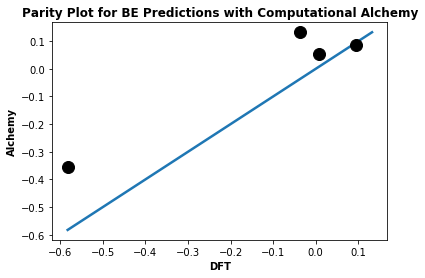

In [26]:
from matplotlib import pyplot as plot
plot.plot([min(dft_del_be+alc_del_be),max(dft_del_be+alc_del_be)],
          [min(dft_del_be+alc_del_be),max(dft_del_be+alc_del_be)],
          linewidth=2.5)
plot.plot(dft_del_be,alc_del_be,'ko',markersize=12)
plot.xlabel('DFT',weight='bold')
plot.ylabel('Alchemy',weight='bold')
plot.title('Parity Plot for BE Predictions with Computational Alchemy',weight='bold')

Below is a summary of pertinent quantities for this analysis. We can read through the list of absolute errors printed below and identify systems with inaccurate BE predictions. For these systems with low accuracy, we can look at the magnitude of the ESP difference and the transmutation index (location of transmuted atom). Low accuracy is typically attributed to systems where transmutations are made to atoms where the magnitude of the ESP difference is large.

In [27]:
from numpy import average
ae = [round(abs(alc_del_be[i] - dft_del_be[i]),3) for i in range(len(new_transmute))]
mae = round(average(ae),3)

In [28]:
new_transmute_espdiffs = [diffs[i] for i in new_transmute]
print('Transmutation Index')
print(new_transmute)
print('')
print('Electrostatic Potential Difference at Transmutation Index')
print(new_transmute_espdiffs)
print('')
print('Delta Binding Energy Calculated with Alchemy (Dot Product of Above Arrays):')
print(alc_del_be)
print('')
print('Delta Binding Energy Calculated with DFT:')
print(dft_del_be)
print('')
print('Absolute Errors:')
print(ae)
print('')
print('Mean Absolute Error')
print(mae)
print('')

Transmutation Index
[1, 19, 3, 4]

Electrostatic Potential Difference at Transmutation Index
[-0.427, 0.0166, -0.0152, 0.062]

Delta Binding Energy Calculated with Alchemy (Dot Product of Above Arrays):
[-0.3567, 0.0869, 0.0551, 0.1323]

Delta Binding Energy Calculated with DFT:
[-0.5827, 0.0936, 0.0088, -0.0372]

Absolute Errors:
[0.226, 0.007, 0.046, 0.169]

Mean Absolute Error
0.112

